# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn

seaborn.set(palette="summer")

In [ ]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\knyze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset("ag_news")

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
set(dataset["train"]["label"])

{0, 1, 2, 3}

In [ ]:
words = Counter()

for example in tqdm(dataset["train"]["text"]):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans("", "", string.punctuation)
    )

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(["<unk>", "<bos>", "<eos>", "<pad>"])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f"Vocab size: {len(vocab)}")

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind["<unk>"]
        self.bos_id = word2ind["<bos>"]
        self.eos_id = word2ind["<eos>"]
        self.pad_id = word2ind["<pad>"]

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = (
            self.data[idx]["text"]
            .lower()
            .translate(str.maketrans("", "", string.punctuation))
        )
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
        ]
        tokenized_sentence += [self.eos_id]

        train_sample = {"text": tokenized_sentence, "label": self.data[idx]["label"]}

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind["<pad>"], max_len=256
) -> torch.Tensor:
    seq_lens = [len(x["text"]) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence["text"] = sequence["text"][:max_seq_len]
        for _ in range(max_seq_len - len(sequence["text"])):
            sequence["text"].append(pad_id)

        new_batch.append(sequence["text"])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x["label"] for x in input_batch]).to(device)

    new_batch = {"input_ids": sequences, "label": labels}

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset["train"])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset["test"])), 10000)
eval_dataset = WordDataset(dataset["test"].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size,
)

eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=False,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size,
)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch["input_ids"])
            predictions.append(logits.argmax(dim=1))
            target.append(batch["label"])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int, num_classes: int = 4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.linear2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.1)
        self.non_lin = nn.ReLU()

    def forward(self, input_butch) -> torch.tensor:
        embeddings = self.embedding(input_butch)
        output, _ = self.rnn(embeddings)

        mean_pooled = output.mean(dim=1)
        max_pooled = output.max(dim=1)[0]
        pooled = torch.cat([mean_pooled, max_pooled], dim=-1)

        output = self.dropout(self.linear1(self.non_lin(pooled)))
        output = self.dropout(self.linear2(self.non_lin(output)))
        prediction = self.projection(output)

        return prediction

In [ ]:
model = Model(vocab_size=len(vocab), hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = ReduceLROnPlateau(
    optimizer, mode="max", patience=3, verbose=True, factor=0.5, min_lr=1e-6
)

In [ ]:
num_epochs = 10

losses = []
accuracies = []

best_accuracy = 0.0
save_path = "best_model.pt"

for epooch in range(num_epochs):
    epoch_loss = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"epoch: {epooch}")):
        optimizer.zero_grad()
        logits = model(batch["input_ids"])
        loss = criterion(logits, batch["label"])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    model.eval()
    accuracy = evaluate(model, eval_dataloader)
    accuracies.append(accuracy)
    losses.append(sum(epoch_loss) / len(epoch_loss))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with accuracy = {accuracy:.4f}")

    scheduler.step(accuracy)

    model.train()

0.012211650493665365


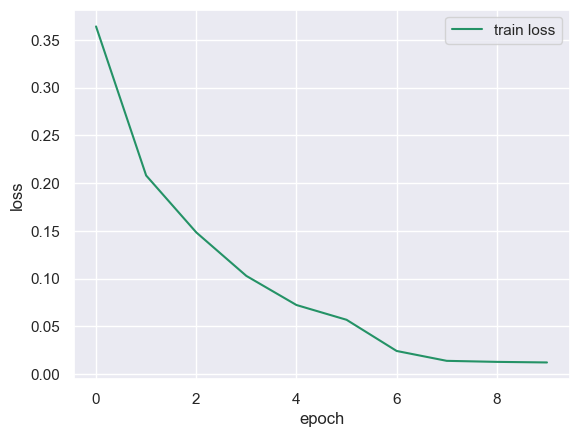

In [ ]:
x = list(range(len(losses)))

print(min(losses))
plt.plot(x, losses, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

0.9163999557495117


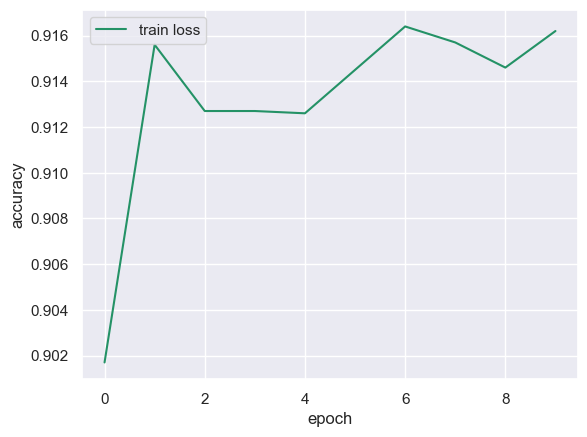

In [ ]:
x = list(range(len(accuracies)))

print(max(accuracies))

plt.plot(x, accuracies, label="train accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()